In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import csv
import tqdm
import sys
import random

if 'google.colab' in sys.modules or 'ipykernel' in sys.modules:
    from tqdm.notebook import tqdm  # Google Colaboratory or Jupyter Notebook
else:
    from tqdm import tqdm    # ipython, python script, ...

neigbor_grids = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])

In [6]:
class GridMapWorld():
    def __init__(
        self,
        grid_step=np.array([0.1, 0.1]),
        grid_num=np.array([100, 100]),
        time_span=10,
        time_interval=0.1,
        map_data="map1.csv",
        debug=False,
        is_dynamic=False,
        time_show="step"
    ):
        self.objects = []
        self.grid_step = np.array(grid_step)
        self.grid_num = np.array(grid_num)
        self.time_span = time_span
        self.time_interval = time_interval
        self.map_data = map_data
        self.debug = debug
        self.is_dynamic = is_dynamic
        self.time_show = time_show
        self.step = 0
        self.start_index = np.array([-1, -1])
        self.goal_index = np.array([-1, -1])
        
        with open(self.map_data) as f:
            reader = csv.reader(f)
            self.grid_map = np.array([row for row in reader]).T
        
        for index, grid in np.ndenumerate(self.grid_map):
            if grid == '2':  #Start
                self.start_index = np.array(index)
            elif grid == '3':  #Goal
                self.goal_index = np.array(index)
        
    def append(self,obj):
        self.objects.append(obj)
    
    def draw(self, figsize=(4, 4)):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.grid_step[0]*self.grid_num[0])
        ax.set_ylim(0, self.grid_step[1]*self.grid_num[1])
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=10)
        
        for index, grid in np.ndenumerate(self.grid_map):
            if(grid == '2' or self.isStart(index)):   #Start
                clr = "orange"
            elif(grid == '3' or self.isGoal(index)):   #Goal
                clr = "green"
            elif(grid == '1'):     #Unoccupied
                continue
            elif(grid == '0'):   #Obstacles
                if(self.is_dynamic):
                    clr = "lightgray"
                else:
                    clr = "black"
            else:
                continue
            self.drawGrid(index, clr, 1.0, ax)
            
        elems = []
        
        if self.debug:
            for i in tqdm(range(int(self.time_span/self.time_interval))): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(
                fig, self.one_step, fargs=(elems, ax),
                frames=int(self.time_span/self.time_interval)+1,
                interval=int(self.time_interval*1000),
                repeat=False
            )
            plt.show()
    
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        
        if(self.time_show == "time"):
            time_str = "t = %.2f[s]" % (self.time_interval*i)
        elif(self.time_show == "step"):
            time_str = "step = " + str(i)
        else:
            time_str = ""
            
        elems.append(
            ax.text(
                self.grid_step[0]*self.grid_num[0]*0.01,
                self.grid_step[1]*self.grid_num[1]*1.02,
                time_str,
                fontsize=10
            )
        )
        
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)
    
    def drawGrid(self, index, color, alpha, ax, fill=True, elems=None):
        xy = index * self.grid_step
        r = patches.Rectangle(
            xy=(xy),
            height=self.grid_step[0],
            width=self.grid_step[1],
            color=color,
            alpha=alpha,
            fill=fill
        )
        if(elems is not None):
            elems.append(ax.add_patch(r))
        else:
            ax.add_patch(r)
    
    def isObstacle(self, index):
        if(self.isOutOfBounds(index)):
            return True
        if(self.grid_map[index[0], index[1]] == '0'):
            return True
        else:
            return False
        
    def isOutOfBounds(self, index):
        if(np.any(index >= self.grid_num) or np.any(index < [0, 0])):
            return True
        else:
            return False
    
    def isStart(self, index):
        if(np.all(index == self.start_index)):
            return True
        else:
            return False
    
    def isGoal(self, index):
        if(np.all(index == self.goal_index)):
            return True
        else:
            return False
        
    def resetStartAndGoal(self, start_index=None, goal_index=None, distance=100):
        if np.any(self.start_index != None):
            self.grid_map[self.start_index[0]][self.start_index[1]] = '1'
        if np.any(self.goal_index != None):
            self.grid_map[self.goal_index[0]][self.goal_index[1]] = '1'
        if np.any(start_index == None) or np.any(goal_index == None):
            self.start_index = np.array([random.randint(0, self.grid_num[0] - 1), random.randint(0, self.grid_num[1] - 1)])
            self.goal_index = np.array([random.randint(0, self.grid_num[0] - 1), random.randint(0, self.grid_num[1] - 1)])
            while(self.isObstacle(self.start_index) or self.isObstacle(self.goal_index) or self.distance(self.start_index, self.goal_index) < distance):
                self.start_index = np.array([random.randint(0, self.grid_num[0] - 1), random.randint(0, self.grid_num[1] - 1)])
                self.goal_index = np.array([random.randint(0, self.grid_num[0] - 1), random.randint(0, self.grid_num[1] - 1)])
        else:
            self.start_index = start_index
            self.goal_index = goal_index
        self.grid_map[self.start_index[0]][self.start_index[1]] = '2'
        self.grid_map[self.goal_index[0]][self.goal_index[1]] = '3'
        
    def distance(self, index1, index2):
        return np.linalg.norm(index1 - index2)

<IPython.core.display.Javascript object>


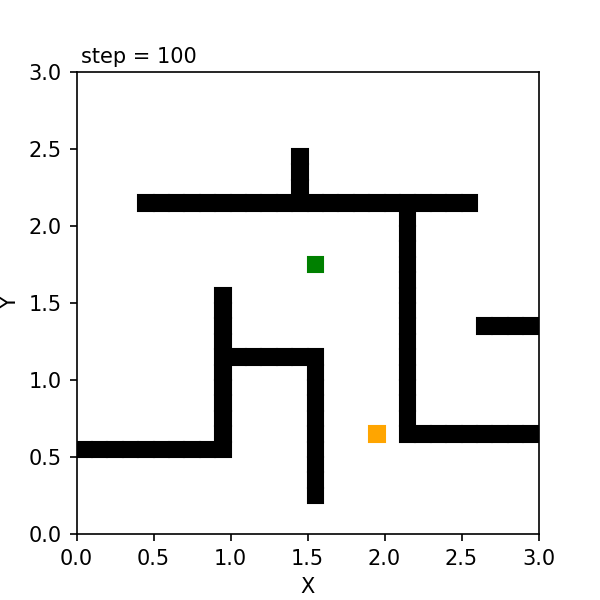

In [9]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.1

    grid_step = [0.1, 0.1]
    grid_num = [30, 30]

    map_data = "csvmap/map2.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False, is_dynamic=False)
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=60)    #アニメーション保存